In [1]:
%%time
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
from matplotlib import style
#sta matplotlib to inline and displays graphs below the corresponding cell.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#Tensorflow Keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional,Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical


# nltk
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
from collections import Counter
import logging
import time
import pickle
import itertools



print(f"Above Libraries were successfully loaded")

Above Libraries were successfully loaded
Wall time: 5.95 s


In [70]:
df=pd.read_csv(r"C:\Users\Praveen Bhargav\Desktop\INTERNSHIPS\PreSkale\Sentiment_Analysis\Twitter Analysis\EDA FOR REVIEWS DATASET/Cleaned_reviews.csv",index_col="Unnamed: 0")
df.head()

,userName,content,score,Polarity,clean_text,common_words
0,Andrew Thomas,Update: After getting a response from the deve...,1,Negative,update getting response developer would change...,"['update', 'getting', 'response', 'developer',..."
1,Craig Haines,Used it for a fair amount of time without any ...,1,Negative,used fair amount time without problem suddenly...,"['used', 'fair', 'amount', 'time', 'without', ..."
2,steven adkins,Your app sucks now!!!!! Used to be good but no...,1,Negative,app suck used good doesnt update physically op...,"['app', 'suck', 'used', 'good', 'doesnt', 'upd..."
3,Lars Panzerbjørn,"It seems OK, but very basic. Recurring tasks n...",1,Negative,seems ok basic recurring task need work actual...,"['seems', 'ok', 'basic', 'recurring', 'task', ..."
4,Scott Prewitt,Absolutely worthless. This app runs a prohibit...,1,Negative,absolutely worthless app run prohibitively clu...,"['absolutely', 'worthless', 'app', 'run', 'pro..."


In [71]:
df.columns

Index(['userName', 'content', 'score', 'Polarity', 'clean_text',
       'common_words'],
      dtype='object')

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15746 entries, 0 to 15745
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   userName      15746 non-null  object
 1   content       15746 non-null  object
 2   score         15746 non-null  int64 
 3   Polarity      15746 non-null  object
 4   clean_text    15737 non-null  object
 5   common_words  15746 non-null  object
dtypes: int64(1), object(5)
memory usage: 861.1+ KB


Some columns which i perceived are not useful for the modeling purpose and the target columns "Polarity" is essential to be encoded

In [73]:
df.drop(["score"],1,inplace=True)

In [60]:
df.columns

Index(['userName', 'content', 'Polarity', 'clean_text', 'common_words'], dtype='object')

In [5]:
df.Polarity.value_counts()

Positive    5676
Neutral     5042
Negative    5028
Name: Polarity, dtype: int64

Label Encoding the Polarity

In [74]:
cond=[df.Polarity=="Positive",df.Polarity=="Neutral",df.Polarity=="Negative"]
choice=[2,1,0]
df.Polarity=np.select(cond,choice)
df.Polarity.head()

0    0
1    0
2    0
3    0
4    0
Name: Polarity, dtype: int32

In [75]:
df.Polarity.value_counts() # checking with value_counts before label encoding

2    5676
1    5042
0    5028
Name: Polarity, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15746 entries, 0 to 15745
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   userName      15746 non-null  object
 1   Polarity      15746 non-null  int32 
 2   clean_text    15737 non-null  object
 3   common_words  15746 non-null  object
dtypes: int32(1), object(3)
memory usage: 553.6+ KB


In [7]:
df.isnull().sum()

userName        0
Polarity        0
clean_text      9
common_words    0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
X=df.clean_text
y=df.Polarity

In [15]:
%%time
df.common_words

Wall time: 0 ns


0        ['update', 'getting', 'response', 'developer',...
1        ['used', 'fair', 'amount', 'time', 'without', ...
2        ['app', 'suck', 'used', 'good', 'doesnt', 'upd...
3        ['seems', 'ok', 'basic', 'recurring', 'task', ...
4        ['absolutely', 'worthless', 'app', 'run', 'pro...
                               ...                        
15741    ['believe', 'far', 'best', 'app', 'helping', '...
15742                        ['sometimes', 'crash', 'lot']
15743                             ['work', 'well', 'need']
15744                                             ['love']
15745    ['really', 'amazing', 'helped', 'sooo', 'much'...
Name: common_words, Length: 15737, dtype: object

In [16]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
embedding_dim = 300
vocab_size=1000
padding_type='post'
trunc_type='post'
oov_tok = "<OOV>"
max_length=150
EPOCHS= 20

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# # EXPORT
# KERAS_MODEL = "model.h5"
# WORD2VEC_MODEL = "model.w2v"
# TOKENIZER_MODEL = "tokenizer.pkl"
# ENCODER_MODEL = "encoder.pkl"

In [17]:
w2v_model = Word2Vec(size=W2V_SIZE,window=W2V_WINDOW,
                     min_count=W2V_MIN_COUNT,workers=8)

In [18]:
documents = [_text.split() for _text in df.clean_text] 
documents

[['update',
  'getting',
  'response',
  'developer',
  'would',
  'change',
  'rating',
  'star',
  'possible',
  'guy',
  'hide',
  'behind',
  'confusing',
  'opaque',
  'term',
  'refuse',
  'budge',
  'im',
  'annoyed',
  'money',
  'lost',
  'really',
  'terrible',
  'customer',
  'experience',
  'original',
  'careful',
  'signing',
  'free',
  'trial',
  'app',
  'happen',
  'go',
  'automatically',
  'charge',
  'full',
  'year',
  'subscription',
  'refuse',
  'refund',
  'terrible',
  'customer',
  'experience',
  'app',
  'ok'],
 ['used',
  'fair',
  'amount',
  'time',
  'without',
  'problem',
  'suddenly',
  'asked',
  'create',
  'account',
  'log',
  'using',
  'google',
  'fb',
  'used',
  'google',
  'one',
  'discover',
  'everything',
  'gone'],
 ['app',
  'suck',
  'used',
  'good',
  'doesnt',
  'update',
  'physically',
  'open',
  'close',
  'scroll',
  'finally',
  'show',
  'want',
  'put',
  'list',
  'friggen',
  'paid',
  'garbage'],
 ['seems',
  'ok',
  '

In [19]:
w2v_model.build_vocab(documents)


In [20]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2341


In [21]:
print(words)

dict_keys(['update', 'getting', 'response', 'developer', 'would', 'change', 'rating', 'star', 'possible', 'guy', 'hide', 'behind', 'confusing', 'term', 'refuse', 'im', 'annoyed', 'money', 'lost', 'really', 'terrible', 'customer', 'experience', 'original', 'careful', 'signing', 'free', 'trial', 'app', 'happen', 'go', 'automatically', 'charge', 'full', 'year', 'subscription', 'refund', 'ok', 'used', 'fair', 'amount', 'time', 'without', 'problem', 'suddenly', 'asked', 'create', 'account', 'log', 'using', 'google', 'fb', 'one', 'discover', 'everything', 'gone', 'suck', 'good', 'doesnt', 'open', 'close', 'scroll', 'finally', 'show', 'want', 'put', 'list', 'paid', 'garbage', 'seems', 'basic', 'recurring', 'task', 'need', 'work', 'actually', 'useful', 'example', 'nice', 'able', 'set', 'first', 'every', 'month', 'edit', 'also', 'noticed', 'dark', 'theme', 'may', 'available', 'option', 'ill', 'never', 'know', 'since', 'reason', 'try', 'thus', 'pay', 'actual', 'premium', 'absolutely', 'worthless

In [22]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

Wall time: 11.2 s


(6801735, 8844960)

In [23]:
w2v_model.most_similar("love")

[('great', 0.5305055379867554),
 ('awesome', 0.4551678001880646),
 ('fantastic', 0.4211962819099426),
 ('amazing', 0.40623319149017334),
 ('like', 0.4052516222000122),
 ('perfect', 0.4007713198661804),
 ('beautiful', 0.3848797380924225),
 ('enjoy', 0.378772497177124),
 ('excellent', 0.3749626874923706),
 ('loved', 0.36299145221710205)]

In [24]:
vector = w2v_model.wv['update']

In [25]:
len(vector)

300

### Using Deep Learning

In [10]:
# Initializing Hyper params

embedding_dim = 300
vocab_size=10000
padding_type='post'
trunc_type='post'
oov_tok = "<OOV>"
max_length=200

IMPORTANT NOTE:
- As the given target label which we need to predict is Multi-Label classes, and its mandatory to use the softmax.Before using the softmax lets change the "Y LABEL" by one hot representation.

In [12]:
y.shape

(15737,)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (11015,)
y_train: (11015,)
X_test: (4722,)
y_test: (4722,)


In [91]:
train_sentences=[]
train_labels=[]
validation_sentences=[]
validation_labels=[]
for i in X_train:
  train_sentences.append(i)

for i in y_train:
  train_labels.append(i)

for i in X_test:
  validation_sentences.append(i)

for i in y_test:
  validation_labels.append(i)

In [92]:
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

11015
11015
4722
4722


In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) 
tokenizer.fit_on_texts(X_train)  
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train) 
train_padded = pad_sequences(train_sequences, padding = padding_type, maxlen=max_length) 
print(len(train_sequences[0]))
print(len(train_padded[0]))

9
200


In [29]:
print("Length of sequence == ",len(train_sequences))
for i in range(0,10):
    print("sentence: {0}\nsequences: {1} ".format(X_train.iloc[i],train_sequences[i]))


Length of sequence ==  11015
sentence: dont friggin know yet installed note havent spent time
sequences: [18, 4027, 111, 250, 382, 115, 333, 547, 4] 
sentence: work linked another calendar appand difficult change time pm
sequences: [13, 1136, 126, 12, 3391, 465, 54, 4, 1013] 
sentence: اغلب الميزات الهامة مدفوعة
sequences: [4028, 4029, 4030, 4031] 
sentence: like idea working outlook calendar properly big drawback
sequences: [5, 123, 91, 312, 12, 337, 281, 1495] 
sentence: jump wholeheartedly using app integration google calendar exactly im looking see search feature android worse still android search roadmap since still done meantime apps build smart list tag status free text seriously behind curve guy
sequences: [1333, 6120, 35, 2, 313, 38, 12, 417, 27, 116, 41, 451, 15, 140, 742, 50, 140, 451, 3392, 117, 50, 108, 6121, 52, 765, 619, 7, 441, 847, 47, 522, 671, 479, 1381, 345] 
sentence: kind confusing use supposed
sequences: [321, 314, 6, 583] 
sentence: add task wunderlist
sequences

In [15]:
validation_sequences = tokenizer.texts_to_sequences(X_test) 
validation_padded = pad_sequences(validation_sequences, padding = padding_type, maxlen=max_length) 

print(len(validation_sequences))
print(validation_padded.shape)

4722
(4722, 200)


In [16]:
y_train1=to_categorical(y_train,num_classes=3)
y_test1=to_categorical(y_test,num_classes=3)
print(y_train1.shape)
print(y_test1.shape)

(11015, 3)
(4722, 3)


In [96]:
# label_tokenizer = Tokenizer() 
# label_tokenizer.fit_on_texts(df.Polarity)  

# training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels)) 
# validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels)) 


In [97]:
# train_sequences = tokenizer.texts_to_sequences(X_train)
# train_padded= pad_sequences(train_sequences, padding = padding_type, maxlen=max_length) 


In [98]:
# X_train.iloc[0]


In [99]:
# print("Length of sequence == ",len(train_sequences))
# print("\nSOME COMMON EXAMPLES:")
# for i in range(0,11):
#     print("sentence: {0}\nsequences: {1} ".format(X_train.iloc[i],train_sequences[i]))

Now lets pad the test data

In [100]:
# validation_sequences = tokenizer.texts_to_sequences(X_test) 
# validation_padded = pad_sequences(validation_sequences, padding = padding_type, maxlen=max_length) 

# print(len(validation_sequences))
# print(validation_padded.shape)

In [53]:
## Building an Embedding model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
    tf.keras.layers.LSTM(150, return_sequences=True), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100),
   
    tf.keras.layers.Dense(256, activation = 'relu'), 
    tf.keras.layers.Dense(3, activation = 'softmax')
    
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 300)          3000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 200, 150)          270600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 150)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 3,397,627
Trainable params: 3,397,627
Non-trainable params: 0
____________________________________________

CallBacks

- ReduceLROnPlateau
- EarlyStopping

In [54]:
## To avoid overfitting the data we use EarlyStopping

learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)
early_stopping= EarlyStopping(monitor='val_loss',min_delta=0, patience=2)
num_epochs = 30
history = model.fit(train_padded,y_train,batch_size=128,epochs=num_epochs,
          validation_split=0.2,callbacks=[learning_rate_reduction,early_stopping])

Train on 8812 samples, validate on 2203 samples
Epoch 1/30
8812/8812 [==============================] - ETA: 0s - loss: 1.0982 - accuracy: 0.3544

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


8812/8812 [==============================] - 135s 15ms/sample - loss: 1.0982 - accuracy: 0.3544 - val_loss: 1.0973 - val_accuracy: 0.3572
Epoch 2/30
8812/8812 [==============================] - ETA: 0s - loss: 1.0981 - accuracy: 0.3564

8812/8812 [==============================] - 143s 16ms/sample - loss: 1.0981 - accuracy: 0.3564 - val_loss: 1.0977 - val_accuracy: 0.3572
Epoch 3/30
8812/8812 [==============================] - ETA: 0s - loss: 1.0975 - accuracy: 0.3591

8812/8812 [==============================] - 135s 15ms/sample - loss: 1.0975 - accuracy: 0.3591 - val_loss: 1.0978 - val_accuracy: 0.3572


In [21]:
### Building An Embedding Model
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(3, activation = 'softmax'))
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 300)          3000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 3,321,403
Trainable params: 3,321,403
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
## To avoid overfitting the data we use EarlyStopping

learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.5,min_lr=0.00001)
early_stopping= EarlyStopping(monitor='val_loss',min_delta=0, patience=5)
num_epochs = 30
history = model1.fit(train_padded,y_train1,batch_size=128,epochs=num_epochs,
          validation_split=0.2,callbacks=[learning_rate_reduction,early_stopping])

Train on 8812 samples, validate on 2203 samples
Epoch 1/30
8812/8812 [==============================] - 155s 18ms/sample - loss: 0.9697 - accuracy: 0.5109 - val_loss: 0.7897 - val_accuracy: 0.6446
Epoch 2/30
8812/8812 [==============================] - 149s 17ms/sample - loss: 0.6921 - accuracy: 0.7049 - val_loss: 0.7230 - val_accuracy: 0.6886
Epoch 3/30
8812/8812 [==============================] - 146s 17ms/sample - loss: 0.5091 - accuracy: 0.7982 - val_loss: 0.7516 - val_accuracy: 0.6995
Epoch 4/30
8812/8812 [==============================] - 143s 16ms/sample - loss: 0.3816 - accuracy: 0.8571 - val_loss: 0.7956 - val_accuracy: 0.7059
Epoch 5/30
8812/8812 [==============================] - 146s 17ms/sample - loss: 0.2910 - accuracy: 0.8925 - val_loss: 0.8995 - val_accuracy: 0.7068
Epoch 6/30
8812/8812 [==============================] - 147s 17ms/sample - loss: 0.2293 - accuracy: 0.9158 - val_loss: 1.0184 - val_accuracy: 0.7190
Epoch 7/30
8812/8812 [==============================] - 15

In [25]:
%%time
score = model1.evaluate(validation_padded, y_test1, batch_size=128)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])


ACCURACY: 0.72384584
LOSS: 0.9413640134569853
Wall time: 13.4 s


In [27]:
predict=np.argmax(model1.predict(validation_padded), axis=-1)
predict

array([0, 2, 1, ..., 1, 0, 0], dtype=int64)

In [36]:
#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="right",
                 color="White" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


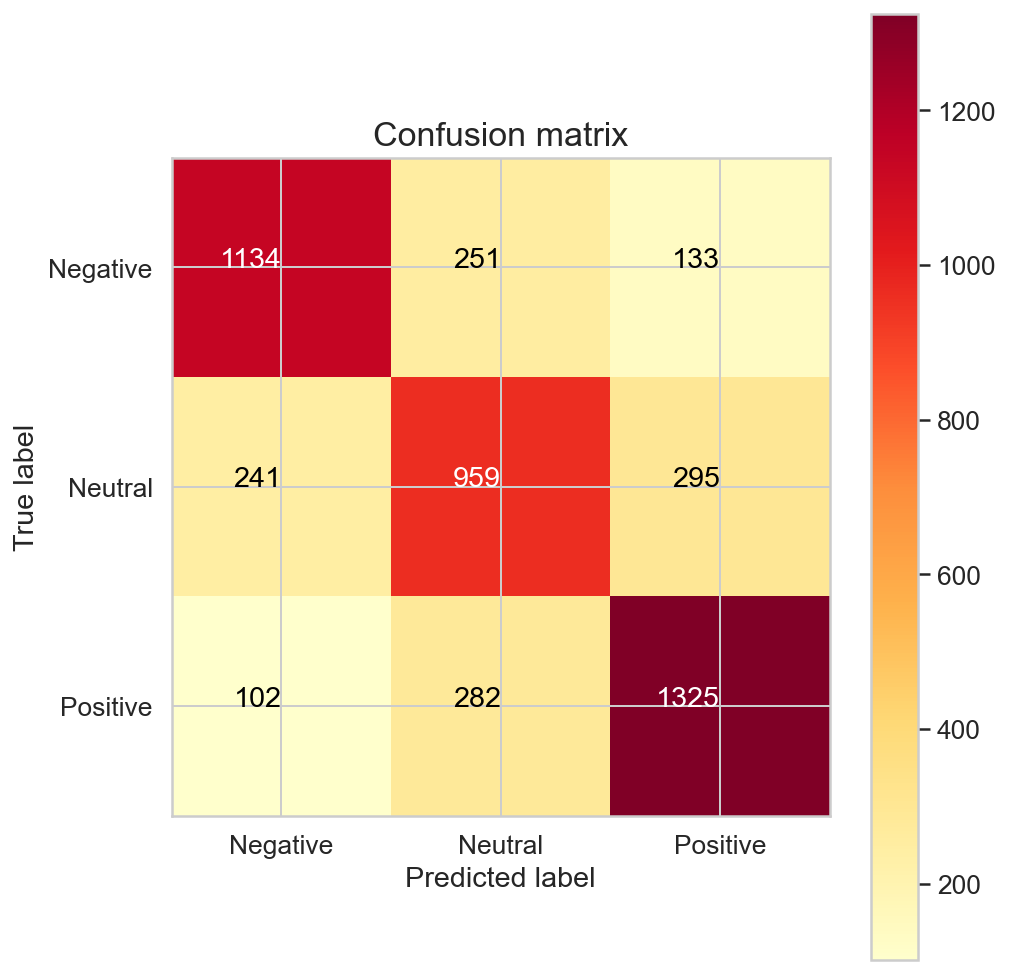

In [37]:
import itertools
plt.figure(figsize=(7,7))
cm = confusion_matrix(y_test,predict)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])
plt.savefig("confusion_matrix.jpg")

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predict)

0.7238458280389666

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      1518
           1       0.64      0.64      0.64      1495
           2       0.76      0.78      0.77      1709

    accuracy                           0.72      4722
   macro avg       0.72      0.72      0.72      4722
weighted avg       0.72      0.72      0.72      4722



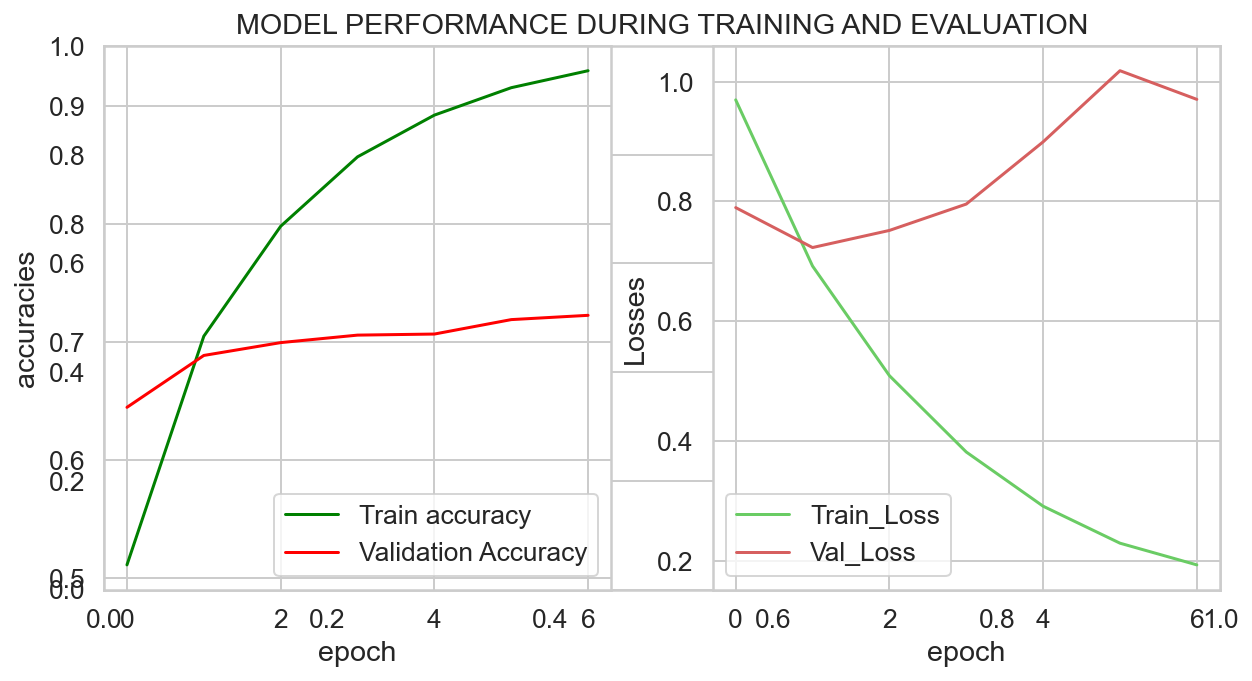

In [41]:
fig=plt.figure(figsize=(10,5))
plt.title("MODEL PERFORMANCE DURING TRAINING AND EVALUATION")
fig1=fig.add_subplot(121)
plt.plot(history.history['accuracy'],color='Green')
plt.plot(history.history["val_accuracy"],color='red')
# plt.ylim(0.90, 1.05)
plt.xlabel("epoch")
plt.ylabel("accuracies")
plt.legend(['Train accuracy','Validation Accuracy'])

fig2=fig.add_subplot(122)
plt.plot(history.history["loss"],color='g')
plt.plot(history.history["val_loss"],color='r')
# plt.ylim(0.0, 1)
plt.xlabel("epoch")
plt.ylabel("Losses")
plt.legend(['Train_Loss','Val_Loss'])

plt.savefig("Model Performance.jpg")
plt.show()

In [42]:
actual=pd.DataFrame({"Actual":list(y_test),"Predicted":list(predict)})
actual.head()

,Actual,Predicted
0,0,0
1,2,2
2,1,1
3,1,1
4,1,1


In [77]:
actual_list_test=list(X_test)
lis=df.loc[df["clean_text"].isin(actual_list_test)].reset_index(drop=True)
lis.drop(["common_words"],1,inplace=True)

In [83]:
X_test.iloc[0]

'cant rely reminder alarm come even select alarm relying app missed important task'

In [84]:
y_test.iloc[0]

0

In [86]:
predict[0]

0

In [89]:
get_X_test=[]
actual_label=[]
predict_label=[]
for i in range(len(X_test)):
    get_X_test.append(X_test.iloc[i])
    actual_label.append(y_test.iloc[i])
    predict_label.append(predict[i])
    
   

In [93]:
tuple_list=list(zip(get_X_test,actual_label,predict_label))

In [94]:
conclude=pd.DataFrame(data=tuple_list,columns=["text","Actual","Predicted"])

In [97]:
conclude.head(50)

,text,Actual,Predicted
0,cant rely reminder alarm come even select alar...,0,0
1,great app almost providing everything want fre...,2,2
2,yas,1,1
3,like app lot refreshing star flexibility setti...,1,1
4,edit reverted old version something issue back...,1,1
5,app phone ipad communicate everything input ph...,1,1
6,app allready great amount customisation surrea...,2,2
7,ребят конечно круто что вы сделали это в виде ...,1,1
8,cool concept sync doesnt work desktop addon ha...,0,0
9,app haas hekped changed life definitely recommend,2,2


In [98]:
lis=df.loc[df["clean_text"].isin(list(conclude.text))].reset_index(drop=True)
lis.head()

,userName,content,Polarity,clean_text,common_words
0,Scott Prewitt,Absolutely worthless. This app runs a prohibit...,0,absolutely worthless app run prohibitively clu...,"['absolutely', 'worthless', 'app', 'run', 'pro..."
1,Chris Lane,BEWARE the trial period is a scam I've been us...,0,beware trial period scam ive using free versio...,"['beware', 'trial', 'period', 'scam', 'ive', '..."
2,John Papp,DON'T BUY PREMIUM! You have to pay for an enti...,0,dont buy premium pay entire year upfront chang...,"['dont', 'buy', 'premium', 'pay', 'entire', 'y..."
3,Jason Thornton,This could be an awesome app. It has great pot...,0,could awesome app great potential except flaw ...,"['could', 'awesome', 'app', 'great', 'potentia..."
4,Ernie Nadeau,Loaded the trial then emailed about cancelatio...,0,loaded trial emailed cancelation email bounced...,"['loaded', 'trial', 'emailed', 'cancelation', ..."


In [100]:
%%time
dfi=pd.merge(conclude,lis,left_on='text',right_on='clean_text',how='inner',indicator=True)

Wall time: 34.9 ms


In [107]:
conclude_data=dfi.drop(["userName","text","Polarity","clean_text","common_words","_merge"],1)
sample_data = conclude_data.sample(frac = 1) 
sample_data.head()

,Actual,Predicted,content
13377,2,2,I love how I can write done everything and it ...
7310,2,2,It's great
1798,2,2,Good
3764,1,2,good
3131,2,2,Good


In [137]:
sample_data1 = conclude_data.sample(frac = 0.8) 
sample_data1.head()

,Actual,Predicted,content
11124,2,2,"Very good Well, it's a great app. I just wish ..."
6487,0,2,Good
357,1,2,good
15212,1,0,Good app. Minus one star because of the consta...
2987,0,2,Good


In [138]:
def function(col):
    if col==0:
        return "Negative"
    elif col==2:
        return "Positive"
    else:
        return "Neutral"
              

In [139]:
sample_data1["Actual"]=sample_data1["Actual"].apply(function)
sample_data1["Predicted"]=sample_data1["Predicted"].apply(function)
sample_data1.reset_index(drop=True,inplace=True)
sample_data1 = sample_data1.reindex(columns=['content',"Actual","Predicted"])
sample_data1.head(10)

,content,Actual,Predicted
0,"Very good Well, it's a great app. I just wish ...",Positive,Positive
1,Good,Negative,Positive
2,good,Neutral,Positive
3,Good app. Minus one star because of the consta...,Neutral,Negative
4,Good,Negative,Positive
5,Too complicated when putting on data. I'll sta...,Negative,Negative
6,I bought the premium. And I can't sync the dat...,Negative,Negative
7,Really unimpressed that I cannot get notificat...,Negative,Neutral
8,"The app itself is really great. However, if yo...",Neutral,Neutral
9,Good,Neutral,Positive


In [145]:
sample_data1.to_csv("submit_list.csv")

## Applying Third Model

In [125]:
model2= Sequential()

model2.add(Embedding(vocab_size, embedding_dim, input_length=max_length))  #(# Your Embedding Layer)
model2.add(Bidirectional(LSTM(150, return_sequences=True)))  #(# An LSTM Layer)
model2.add(Dropout(0.2))  #(# A dropout layer)
model2.add(LSTM(100))  #(# Another LSTM Layer)
model2.add(Dropout(0.2))  #(# A dropout layer)
model2.add(Dense(256, activation='relu'))  #(# A Dense Layer including regularizers)
model2.add(Dense(3, activation='softmax')) 


model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 300)          3000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 300)          541200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 300)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               25856     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                

In [129]:
## To avoid overfitting the data we use EarlyStopping
%%time
learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.5,min_lr=0.00001)
early_stopping= EarlyStopping(monitor='val_loss',min_delta=0, patience=5)
num_epochs = 30
history = model2.fit(train_padded,y_train,batch_size=128,epochs=num_epochs,
          validation_split=0.2,callbacks=[learning_rate_reduction,early_stopping])

Epoch 1/30
69/69 [==============================] - 7s 102ms/step - loss: 1.0970 - accuracy: 0.3609 - val_loss: 1.0975 - val_accuracy: 0.3572
Epoch 2/30
69/69 [==============================] - 7s 102ms/step - loss: 1.0969 - accuracy: 0.3609 - val_loss: 1.0977 - val_accuracy: 0.3572
Epoch 3/30
69/69 [==============================] - 7s 101ms/step - loss: 1.0970 - accuracy: 0.3609 - val_loss: 1.0976 - val_accuracy: 0.3572
Epoch 4/30
69/69 [==============================] - 7s 102ms/step - loss: 1.0968 - accuracy: 0.3609 - val_loss: 1.0973 - val_accuracy: 0.3572
Epoch 5/30
69/69 [==============================] - 7s 101ms/step - loss: 1.0968 - accuracy: 0.3609 - val_loss: 1.0977 - val_accuracy: 0.3572
Epoch 6/30
69/69 [==============================] - 7s 101ms/step - loss: 1.0968 - accuracy: 0.3609 - val_loss: 1.0975 - val_accuracy: 0.3572
Epoch 7/30
69/69 [==============================] - 7s 101ms/step - loss: 1.0971 - accuracy: 0.3609 - val_loss: 1.0975 - val_accuracy: 0.3572
Epoch 

In [130]:
%%time
score = model1.evaluate(validation_padded, y_test, batch_size=128)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

37/37 [==============================] - 1s 23ms/step - loss: 1.4792 - accuracy: 0.7145

ACCURACY: 0.7145277261734009
LOSS: 1.479239821434021
CPU times: user 624 ms, sys: 39.8 ms, total: 664 ms
Wall time: 939 ms


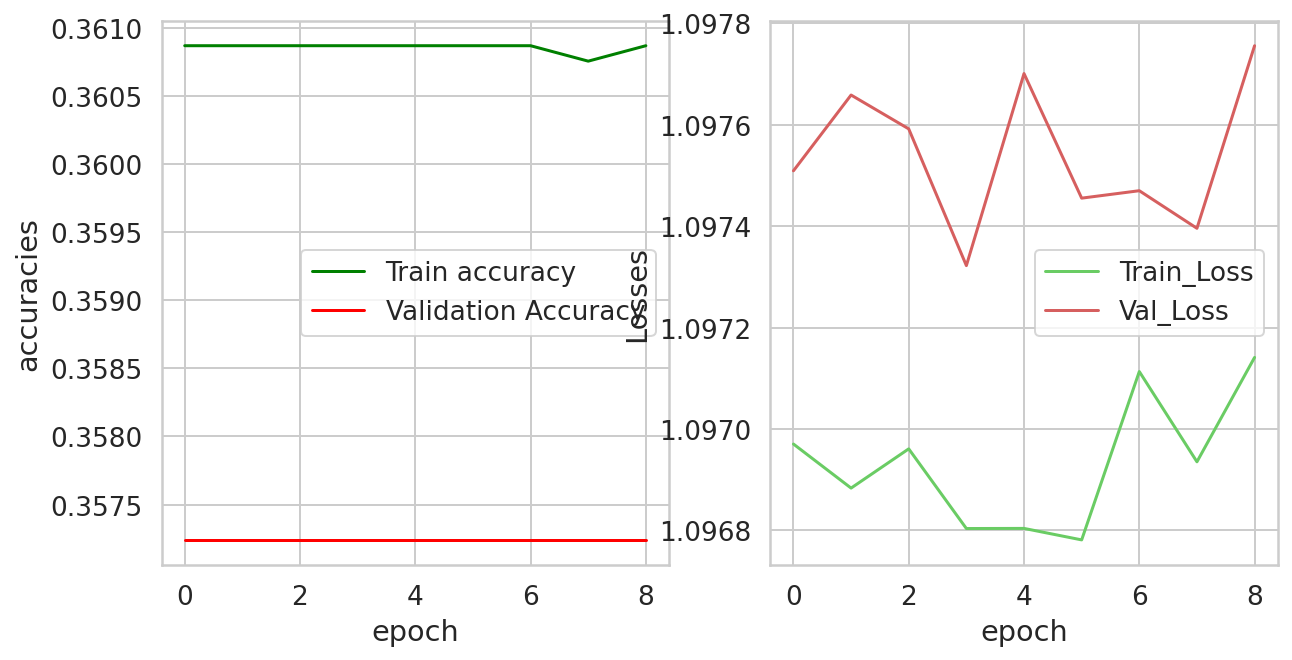

In [131]:
fig=plt.figure(figsize=(10,5))

fig1=fig.add_subplot(121)
plt.plot(history.history['accuracy'],color='Green')
plt.plot(history.history["val_accuracy"],color='red')
# plt.ylim(0.90, 1.05)
plt.xlabel("epoch")
plt.ylabel("accuracies")
plt.legend(['Train accuracy','Validation Accuracy'])

fig2=fig.add_subplot(122)
plt.plot(history.history["loss"],color='g')
plt.plot(history.history["val_loss"],color='r')
# plt.ylim(0.0, 1)
plt.xlabel("epoch")
plt.ylabel("Losses")
plt.legend(['Train_Loss','Val_Loss'])
plt.show()